# Anomaly Detection

In diesem Notebook erproben wir die Erkennung von ungewöhnlichen Bildern.
Dazu nehmen wir den MNIST Datensatz und tauschen 1% der Bilder mit MNIST Fashion Bildern aus. Diese haben das selbe Format, aber zeigen verschiedene Modeartikel.

## Aufgabe
Vergleichen Sie die Ergebnisse der verschiedenen Anomaly-Detection-Methoden:
- Isolation Forest
- Mahalanobis-Distanz
- VAE-Reconstruction Error

Versuchen Sie, die Performance **eines** der folgenden Modelle zu verbessern:
- Classifier
- Generator (Variational Autoencoder)
- Anomaly Detection


Der Code in diesem Notebook wurde mithilfe von ChatGPT in etwa einer Stunde erstellt: [Chatverlauf](https://chatgpt.com/share/3427b25b-43f6-4e7a-8913-1986b7fad027)

In [ ]:
import torch
from torchvision import datasets, transforms
import random

# Transformationen definieren
transform = transforms.Compose([transforms.ToTensor()])

# MNIST und Fashion-MNIST Datasets laden
mnist_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
fashion_mnist_dataset = datasets.FashionMNIST(root='./data', train=True, download=True, transform=transform)

# Sicherstellen, dass die Längen der beiden Datasets passen
assert len(mnist_dataset) >= 600 and len(fashion_mnist_dataset) >= 600, "Datasets müssen mindestens 600 Bilder enthalten."

# 600 zufällige Indizes auswählen
anomaly_indices = random.sample(range(len(mnist_dataset)), 600)
fashion_mnist_indices = random.sample(range(len(fashion_mnist_dataset)), 600)


# MNIST Bilder durch Fashion-MNIST Bilder ersetzen
for mnist_idx, fashion_idx in zip(anomaly_indices, fashion_mnist_indices):
    mnist_dataset.data[mnist_idx] = fashion_mnist_dataset.data[fashion_idx]
    mnist_dataset.targets[mnist_idx] = fashion_mnist_dataset.targets[fashion_idx]



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:10<00:00, 915195.95it/s] 


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 56678.80it/s]


Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:06<00:00, 242617.04it/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 4344476.34it/s]


Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



100%|██████████| 26421880/26421880 [00:12<00:00, 2192734.52it/s]


Extracting ./data/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 29515/29515 [00:00<00:00, 168249.86it/s]


Extracting ./data/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 4422102/4422102 [00:01<00:00, 3132798.60it/s]


Extracting ./data/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./data/FashionMNIST/raw



100%|██████████| 5148/5148 [00:00<00:00, 18957223.00it/s]

Extracting ./data/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/FashionMNIST/raw



Hier betrachten wir ein paar Beispielbilder des originalen Datensatz sowie einige der ersetzten Bilder.

beliebige Bilder


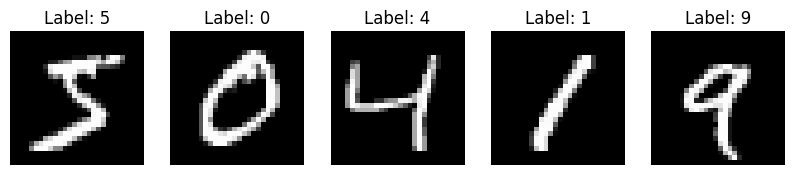

Ersetzte Bilder


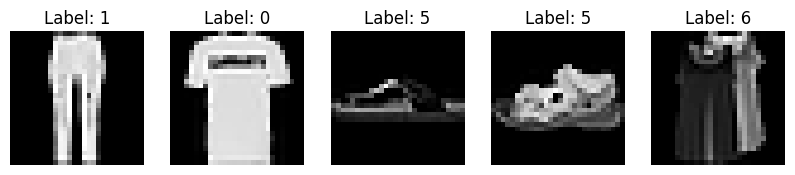

In [ ]:
# Ergebnis überprüfen: Beispielbilder anzeigen
import matplotlib.pyplot as plt

print("beliebige Bilder")

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(mnist_dataset.data[i], cmap='gray')
    ax.set_title(f"Label: {mnist_dataset.targets[i].item()}")
    ax.axis('off')

plt.show()

# Ergebnis überprüfen: Ersetzte Bilder anzeigen

print("Ersetzte Bilder")

fig, axes = plt.subplots(1, 5, figsize=(10, 2))
for i, ax in enumerate(axes):
    ax.imshow(mnist_dataset.data[anomaly_indices[i]], cmap='gray')
    ax.set_title(f"Label: {mnist_dataset.targets[anomaly_indices[i]].item()}")
    ax.axis('off')

plt.show()


## Ansatz: Classifier

Bei diesem Datensatz haben wir label, wir können also einen Classifier trainieren. In dessen vorletzter Schicht lernt er high-level features, die zur Klassifizierung der Bilder genutzt werden.
Um diese Features nach dem Training zu erreichen, sondern wir die Berechnung der features in eine andere Funktion ab, die wir spaeter gesondert aufrufen können.
Da die Anzahl der Features für den Entscheidungsprozess wichtig ist, lassen wir diesen Parameter frei wählbar.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split

class Classifier(nn.Module):
    def __init__(self, N_hidden=64):
        super(Classifier, self).__init__()
        self.layer1 = nn.Linear(28 * 28, N_hidden)  # Eingabeschicht zu ersten versteckten Layer
        self.relu1 = nn.ReLU()                # ReLU nach dem ersten versteckten Layer
        self.layer2 = nn.Linear(N_hidden, N_hidden)       # Erster versteckter Layer zu zweitem versteckten Layer
        self.relu2 = nn.ReLU()                # ReLU nach dem zweiten versteckten Layer
        self.layer3 = nn.Linear(N_hidden, N_hidden)       # Zweiter versteckter Layer zu drittem versteckten Layer
        self.relu3 = nn.ReLU()                # ReLU nach dem dritten versteckten Layer
        self.output_layer = nn.Linear(N_hidden, 10) # Letzter versteckter Layer zu Output Layer

    def forward(self, x):
        x = self.relu3(self.features(x))      # High-Level Features berechnen
        x = self.output_layer(x)              # Output Layer
        return x

    def features(self, x):
        x = x.view(-1, 28 * 28)               # Eingabedaten flach machen
        x = self.relu1(self.layer1(x))        # Schicht 1 und ReLU 1
        x = self.relu2(self.layer2(x))        # Schicht 2 und ReLU 2
        x = self.layer3(x)                    # Schicht 3 und ReLU 3
        return x



Wir trainieren den Classsifier für 10 Epochen, so dass er eine akzeptable Accuracy bekommt.

In [ ]:
# Modell, Loss-Funktion und Optimizer initialisieren
N_hidden = 32

model = Classifier(N_hidden=N_hidden)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Daten in Trainings- und Validierungs-Sets aufteilen
train_size = int(0.8 * len(mnist_dataset))
val_size = len(mnist_dataset) - train_size
train_dataset, val_dataset = random_split(mnist_dataset, [train_size, val_size])

# DataLoader für Training und Validierung erstellen
train_loader = DataLoader(train_dataset, batch_size=256, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=256, shuffle=False)

# Training des Modells
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    # Validierung nach jedem Epoch
    model.eval()
    val_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    print(f'Epoch [{epoch+1}/{num_epochs}], '
          f'Training Loss: {running_loss/len(train_loader):.4f}, '
          f'Validation Loss: {val_loss/len(val_loader):.4f}, '
          f'Accuracy: {100 * correct / total:.2f}%')


Epoch [1/10], Training Loss: 0.9755, Validation Loss: 0.4364, Accuracy: 87.61%
Epoch [2/10], Training Loss: 0.3619, Validation Loss: 0.3358, Accuracy: 90.64%
Epoch [3/10], Training Loss: 0.2962, Validation Loss: 0.2900, Accuracy: 91.79%
Epoch [4/10], Training Loss: 0.2550, Validation Loss: 0.2671, Accuracy: 92.03%
Epoch [5/10], Training Loss: 0.2243, Validation Loss: 0.2373, Accuracy: 93.05%
Epoch [6/10], Training Loss: 0.1995, Validation Loss: 0.2142, Accuracy: 93.53%
Epoch [7/10], Training Loss: 0.1783, Validation Loss: 0.1938, Accuracy: 94.38%
Epoch [8/10], Training Loss: 0.1631, Validation Loss: 0.1938, Accuracy: 94.12%
Epoch [9/10], Training Loss: 0.1494, Validation Loss: 0.1791, Accuracy: 94.86%
Epoch [10/10], Training Loss: 0.1378, Validation Loss: 0.1725, Accuracy: 94.88%


## Anomaly Detection

Um anomale features zu erkennen, müssen wir die Features des gesamten Datensatzes betrachten.
Da wir die Anomalien kennen, schalten wir in diesem Schritt das shuffling aus, um später die Qualität der Detection mit Precision und Recall bewerten zu können.

Wer werden verschiedene Anomaly Detection methoden anwenden, um die Brauchbarkeit des Modells besser bewerten zu können.

- Isolation Forest
- Mahalanobis Distanz
- Variational Autoencoder

In [ ]:
import numpy as np

# Extrahiere Features aus den Daten
def extract_features(dataloader, model):
    model.eval()
    features_list = []
    labels_list = []
    for images, labels in dataloader:
        with torch.no_grad():
            features = model.features(images).numpy()
            features_list.append(features)
            labels_list.append(labels.numpy())
    return np.vstack(features_list), np.hstack(labels_list)


# Neuer Dataloader ohne shuffle, damit die indices der Anomalien bekannt sind
train_loader_no_shuffle = DataLoader(train_dataset, batch_size=1, shuffle=False)


def calculate_precision_recall(predicted, actual):
    """ Berechnet precision & recall fuer predicted und actual indizes """
    true_positives = len(set(predicted) & set(actual))
    false_positives = len(set(predicted) - set(actual))
    false_negatives = len(set(actual) - set(predicted))

    precision = true_positives / (true_positives + false_positives) if (true_positives + false_positives) > 0 else 0
    recall = true_positives / (true_positives + false_negatives) if (true_positives + false_negatives) > 0 else 0

    return precision, recall


# Extrahiere Features des gesamten Datasets
features, labels = extract_features(train_loader, model)




### Anomaly Detection: Isolation Forest

Ein Isolation Forest (Isolationswald) ist ein Machine-Learning-Algorithmus zur Anomalieerkennung. Er funktioniert, indem er Datenpunkte durch zufälliges Aufteilen von Merkmalen isoliert. Dabei werden Entscheidungsbäume erstellt, die die Daten in immer kleinere Teilmengen zerlegen. Anomalien (Ausreißer) sind jene Punkte, die im Durchschnitt weniger Teilungen benötigen, um isoliert zu werden, da sie sich von den restlichen Datenpunkten stark unterscheiden.


Wichtige Eigenschaften des Isolation Forests:

- Effizienz: Er arbeitet effizient auch mit großen Datensätzen, da er keine dichte Abschätzung benötigt.
- Skalierbarkeit: Gut skalierbar für große und hochdimensionale Daten.
- Unüberwacht: Er benötigt keine gelabelten Daten, sondern identifiziert Anomalien basierend auf den inhärenten Eigenschaften der Daten.

Isolation Forest ist besonders nützlich in Anwendungen wie Betrugserkennung, Netzwerküberwachung oder bei der Identifikation ungewöhnlicher Muster in großen Datensätzen

![](https://www.researchgate.net/publication/352017898/figure/fig1/AS:1029757483372550@1622524724599/Isolation-Forest-learned-iForest-construction-for-toy-dataset.png)


In [ ]:
from sklearn.ensemble import IsolationForest


# Isolation Forest zur Anomalieerkennung verwenden
iso_forest = IsolationForest(contamination=0.01)  # 1% als Anomalien betrachten
anomaly_scores = iso_forest.fit_predict(features)

# Anomalien finden
anomalies = np.where(anomaly_scores == -1)[0]

# Berechnung von Precision und Recall
precision, recall = calculate_precision_recall(anomalies, anomaly_indices)

# Ergebnisse anzeigen
print(f"Anzahl der tatsächlichen Anomalien: {len(anomaly_indices)}")
print(f"Anzahl der vorhergesagten Anomalien: {len(anomalies)}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

Anzahl der tatsächlichen Anomalien: 600
Anzahl der vorhergesagten Anomalien: 480
Precision: 0.0042
Recall: 0.0033


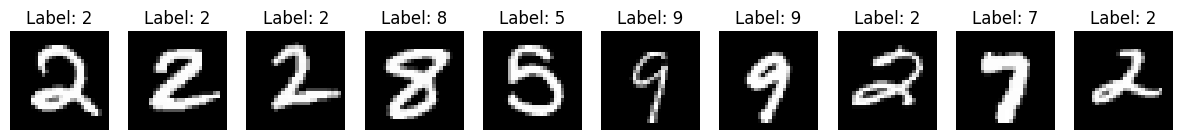

In [ ]:

# zufällige Anomalien auswählen
random_anomalies = random.sample(list(anomalies), min(10, len(anomalies)))

# Anomalien plotten
fig, axes = plt.subplots(1, len(random_anomalies), figsize=(15, 2))
for i, idx in enumerate(random_anomalies):
    axes[i].imshow(mnist_dataset.data[idx].numpy(), cmap='gray')
    axes[i].set_title(f"Label: {mnist_dataset.targets[idx].item()}")
    axes[i].axis('off')

plt.show()



### Ansatz: Mahalanobis Distanz


Die Mahalanobis-Distanz ist eine Metrik zur Messung des Abstands eines Punktes von einer Verteilung unter Berücksichtigung der Korrelationen zwischen den Variablen. Sie wird häufig zur Anomalieerkennung verwendet, da sie die Form und Verteilung der Daten besser berücksichtigt als die gewöhnliche euklidische Distanz.

Anwendung der Mahalanobis-Distanz in der Anomalieerkennung:
- Berechnung des Abstands: Die Mahalanobis-Distanz misst den Abstand eines Datenpunktes zum Zentrum der Datenverteilung (z. B. dem Mittelwert), wobei die Streuung und Korrelationen der Daten berücksichtigt werden. Dies geschieht durch Nutzung der Kovarianzmatrix, die die Variabilität und Beziehungen der Merkmale beschreibt.

- Erkennung von Anomalien: Datenpunkte mit hohen Mahalanobis-Distanzen zum Zentrum gelten als Ausreißer, da sie im Vergleich zu den normalen Datenpunkten ungewöhnlich sind. Der Algorithmus kann so eingestellt werden, dass Punkte, deren Distanz einen bestimmten Schwellenwert überschreitet, als Anomalien klassifiziert werden.

- Robustheit gegenüber multivariaten Daten: Im Gegensatz zu einfachen Distanzmetriken berücksichtigt die Mahalanobis-Distanz die Skala, Streuung und Korrelationen der Daten. Dies macht sie besonders geeignet für die Anomalieerkennung in hochdimensionalen und stark korrelierten Datensätzen.

Die Mahalanobis-Distanz ist besonders nützlich, wenn man die Struktur der Daten exakt erfassen möchte, da sie Ausreißer nicht nur auf Basis der Distanz, sondern auch unter Berücksichtigung der Verteilungseigenschaften der Daten identifiziert.

In [ ]:
from scipy.spatial.distance import mahalanobis
import numpy as np

# Mittelwert und Kovarianzmatrix der Features berechnen
mean = np.mean(features, axis=0)
cov_matrix = np.cov(features, rowvar=False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Mahalanobis-Distanz für jedes Bild berechnen
distances = [mahalanobis(f, mean, inv_cov_matrix) for f in features]

# Schwellenwert setzen (z.B. 99. Perzentil)
threshold = np.percentile(distances, 99)

# Anomalien bestimmen
anomalies1 = np.where(distances > threshold)[0]

# Berechnung von Precision und Recall
precision, recall = calculate_precision_recall(anomalies1, anomaly_indices)

# Ergebnisse anzeigen
print(f"Anzahl der tatsächlichen Anomalien: {len(anomaly_indices)}")
print(f"Anzahl der vorhergesagten Anomalien: {len(anomalies1)}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")



Anzahl der tatsächlichen Anomalien: 600
Anzahl der vorhergesagten Anomalien: 480
Precision: 0.0104
Recall: 0.0083


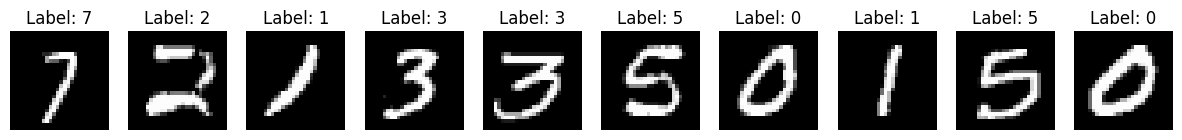

Anzahl der gefundenen Anomalien: 480


In [ ]:

# 5 zufällige Anomalien auswählen, falls es mehr als 5 gibt
random_anomalies = random.sample(list(anomalies), min(10, len(anomalies)))

# Anomalien plotten
fig, axes = plt.subplots(1, len(random_anomalies), figsize=(15, 2))
for i, idx in enumerate(random_anomalies):
    axes[i].imshow(mnist_dataset.data[idx].numpy(), cmap='gray')
    axes[i].set_title(f"Label: {mnist_dataset.targets[idx].item()}")
    axes[i].axis('off')

plt.show()

print(f"Anzahl der gefundenen Anomalien: {len(anomalies)}")


### Ansatz Variational Autoencoder

Ein Variational Autoencoder (VAE) ist ein tiefes, probabilistisches Modell, das zur Anomalieerkennung verwendet werden kann. VAE kombiniert Prinzipien der tiefen Lernmethoden mit probabilistischer Modellierung, um eine latente Repräsentation der Eingabedaten zu lernen. Bei der Anomalieerkennung mit VAE wird das Modell darauf trainiert, die Daten so zu rekonstruieren, dass normale Muster gut wiederhergestellt werden können, während Anomalien schlechter rekonstruiert werden.

Anwendung von VAE zur Anomalieerkennung:
1. Training des VAE: Das VAE wird mit normalen Daten trainiert, um eine kompakte, latente Repräsentation der Daten zu lernen und sie möglichst gut zu rekonstruieren. Das Training zielt darauf ab, die Verteilung der Eingabedaten durch den latenten Raum zu approximieren.

2. Rekonstruktion als Anomaliekriterium: Während der Erkennung wird ein neuer Datenpunkt durch den VAE verarbeitet und rekonstruiert. Die Differenz zwischen dem Original und der Rekonstruktion, gemessen als Rekonstruktionsfehler, dient als Indikator für Anomalien. Datenpunkte mit hohen Rekonstruktionsfehlern sind Anomalien, da das Modell sie nicht gut reproduzieren kann.

3. Wahrscheinlichkeitsbasierter Ansatz: Zusätzlich zur Rekonstruktion schätzt VAE die Wahrscheinlichkeit eines Datenpunktes in der latenten Verteilung. Punkte mit niedriger Wahrscheinlichkeit werden ebenfalls als Anomalien identifiziert.

4. Flexibilität und Anpassungsfähigkeit: VAE sind flexibel und können sich an komplexe Datenverteilungen anpassen, was sie ideal für die Erkennung von Anomalien in hochdimensionalen und nichtlinearen Datenstrukturen macht.

VAEs sind besonders effektiv, weil sie sowohl die strukturellen Muster der Daten als auch die zugrunde liegende Verteilung lernen, was eine leistungsfähige Anomalieerkennung ermöglicht, die über einfache Distanzmetriken hinausgeht.

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, random_split
import torch.nn.functional as F
import numpy as np
import matplotlib.pyplot as plt

# Schritt 1: Einfacher Encoder und Decoder definieren
class Encoder(nn.Module):
    def __init__(self, input_dim=28*28, hidden_dim=64, latent_dim=16):
        super(Encoder, self).__init__()
        self.fc1 = nn.Linear(input_dim, hidden_dim)     # Erste Schicht
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)    # Zweite Schicht
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)    # Dritte Schicht
        self.fc_mu = nn.Linear(hidden_dim, latent_dim)  # Schicht für Mittelwert
        self.fc_logvar = nn.Linear(hidden_dim, latent_dim)  # Schicht für Log-Varianz

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        mu = self.fc_mu(x)
        logvar = self.fc_logvar(x)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self, latent_dim=16, hidden_dim=64, output_dim=28*28):
        super(Decoder, self).__init__()
        self.fc1 = nn.Linear(latent_dim, hidden_dim)    # Erste Schicht
        self.fc2 = nn.Linear(hidden_dim, hidden_dim)    # Zweite Schicht
        self.fc3 = nn.Linear(hidden_dim, hidden_dim)    # Dritte Schicht
        self.fc4 = nn.Linear(hidden_dim, output_dim)    # Output-Schicht

    def forward(self, z):
        z = F.relu(self.fc1(z))
        z = F.relu(self.fc2(z))
        z = F.relu(self.fc3(z))
        recon = torch.sigmoid(self.fc4(z))  # Sigmoid für die Rekonstruktion
        return recon


class VAE(nn.Module):
    def __init__(self, encoder, decoder):
        super(VAE, self).__init__()
        self.encoder = encoder
        self.decoder = decoder

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def forward(self, x):
        mu, logvar = self.encoder(x)
        z = self.reparameterize(mu, logvar)
        recon = self.decoder(z)
        return recon, mu, logvar



# Schritt 2: Verlustfunktion definieren
def vae_loss(recon_x, x, mu, logvar):
    recon_loss = F.binary_cross_entropy(recon_x, x, reduction='sum')    ## Fehler in der Rekonstruktion des Bildes
    kld_loss = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())  ## Abweichung der Latent Features vom Normal
    return recon_loss + kld_loss

# Encoder, Decoder und VAE initialisieren
encoder = Encoder()
decoder = Decoder()
vae = VAE(encoder, decoder)

# Optimizer definieren
optimizer = optim.Adam(vae.parameters(), lr=0.001)

# Schritt 3: Trainingsloop definieren
num_epochs = 20
vae.train()
for epoch in range(num_epochs):
    total_loss = 0
    for images, _ in train_loader:
        images = images.view(-1, 28*28)  # Flatten der Bilder
        optimizer.zero_grad()
        recon, mu, logvar = vae(images)
        loss = vae_loss(recon, images, mu, logvar)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss/len(train_loader.dataset):.4f}")

# Schritt 4: Anomalieerkennung mittels Rekonstruktionsfehler
vae.eval()
reconstruction_errors = []

# Berechnung des Rekonstruktionsfehlers für jedes Bild
with torch.no_grad():
    for images, _ in train_loader_no_shuffle:
        images = images.view(-1, 28*28)
        recon, _, _ = vae(images)
        recon_error = F.mse_loss(recon, images, reduction='none').mean(dim=1)
        reconstruction_errors.extend(recon_error.numpy())

# Schwellenwert für Anomalien festlegen (z.B. 99. Perzentil)
threshold = np.percentile(reconstruction_errors, 99)
anomalies = np.where(reconstruction_errors > threshold)[0]

# Berechnung von Precision und Recall
precision, recall = calculate_precision_recall(anomalies, anomaly_indices)

# Ergebnisse anzeigen
print(f"Anzahl der tatsächlichen Anomalien: {len(anomaly_indices)}")
print(f"Anzahl der vorhergesagten Anomalien: {len(anomalies)}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")



Epoch [1/20], Loss: 178.9518
Epoch [2/20], Loss: 145.9855
Epoch [3/20], Loss: 137.2604
Epoch [4/20], Loss: 134.2242
Epoch [5/20], Loss: 132.3772
Epoch [6/20], Loss: 131.0509
Epoch [7/20], Loss: 130.1205
Epoch [8/20], Loss: 129.3588
Epoch [9/20], Loss: 128.7521
Epoch [10/20], Loss: 128.2254
Epoch [11/20], Loss: 127.7292
Epoch [12/20], Loss: 127.3743
Epoch [13/20], Loss: 126.9704
Epoch [14/20], Loss: 126.7016
Epoch [15/20], Loss: 126.4057
Epoch [16/20], Loss: 126.2293
Epoch [17/20], Loss: 125.9657
Epoch [18/20], Loss: 125.7216
Epoch [19/20], Loss: 125.5475
Epoch [20/20], Loss: 125.4399
Anzahl der tatsächlichen Anomalien: 600
Anzahl der vorhergesagten Anomalien: 480
Precision: 0.0146
Recall: 0.0117


Hier betrachten wir die allgemeine Qualität der Rekonstruktion

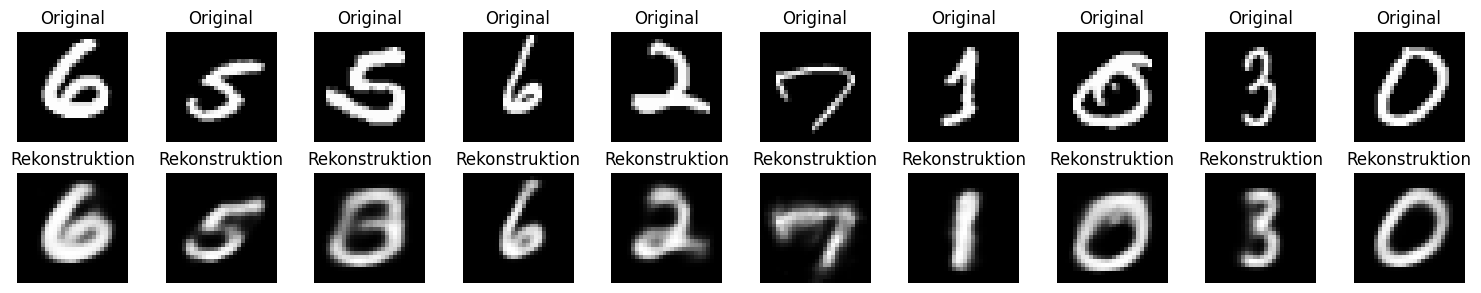

In [ ]:
import torch
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader

# Modell auf den Evaluationsmodus setzen
vae.eval()

# DataLoader erstellen (ohne Shuffle, um die Bilder in der Reihenfolge zu behalten)
train_loader = DataLoader(train_dataset, batch_size=10, shuffle=False)

# Einige Bilder aus dem Trainingsdatensatz rekonstruieren
with torch.no_grad():
    # Nimm eine Batch von Bildern aus dem DataLoader
    for images, _ in train_loader:
        images = images.view(-1, 28*28)  # Flatten der Bilder
        reconstructions, _, _ = vae(images)  # Rekonstruktion durch den VAE
        break  # Nur die erste Batch verwenden

# Konvertiere die Bilder und Rekonstruktionen wieder in 2D-Form
images = images.view(-1, 28, 28)
reconstructions = reconstructions.view(-1, 28, 28)

# Originale und Rekonstruktionen anzeigen
fig, axes = plt.subplots(2, 10, figsize=(15, 3))
for i in range(10):
    # Originalbilder
    axes[0, i].imshow(images[i].numpy(), cmap='gray')
    axes[0, i].axis('off')
    axes[0, i].set_title("Original")

    # Rekonstruierte Bilder
    axes[1, i].imshow(reconstructions[i].numpy(), cmap='gray')
    axes[1, i].axis('off')
    axes[1, i].set_title("Rekonstruktion")

plt.tight_layout()
plt.show()


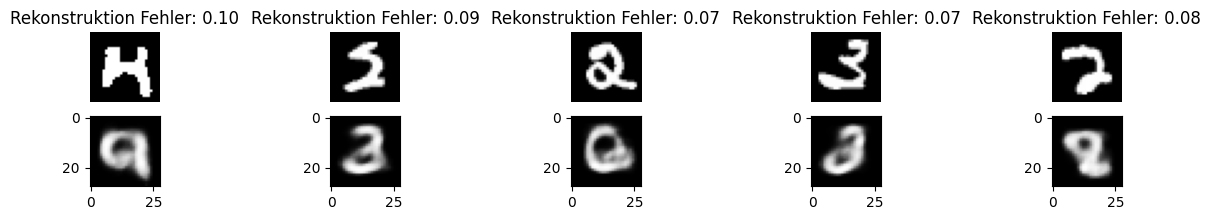

In [ ]:

# 5 zufällige Anomalien anzeigen
random_anomalies = random.sample(list(anomalies), min(5, len(anomalies)))
fig, axes = plt.subplots(2, len(random_anomalies), figsize=(15, 2))
for i, idx in enumerate(random_anomalies):
    axes[0,i].imshow(train_dataset[idx][0].view(28, 28).numpy(), cmap='gray')
    with torch.no_grad():
        axes[1,i].imshow(vae(train_dataset[idx][0].view(1,-1))[0].view(28, 28).numpy(), cmap='gray')
    axes[0,i].set_title(f"Rekonstruktion Fehler: {reconstruction_errors[idx]:.2f}")
    axes[0,i].axis('off')

plt.show()
